# Practical Statistics for Data Scientists (Python)
# Chapter 7. Unsupervised Learning - k-means
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [5]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

In [3]:
!pip install prince

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

# K-Means Clustering
## A Simple Example

In [7]:
SP500_DATA_CSV = 'data/sp500_data.csv.gz'
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df)

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        0
2011-01-04  0.168668 -0.584516        3
2011-01-05  0.026631  0.446985        0
2011-01-06  0.248558 -0.919751        3
2011-01-07  0.337329  0.180511        0
...              ...       ...      ...
2015-06-25 -0.919998 -1.110001        1
2015-06-26  0.029999  0.360000        0
2015-06-29 -0.230003 -0.809998        3
2015-06-30 -0.540001 -0.979996        3
2015-07-01 -0.909996 -0.210007        3

[1131 rows x 3 columns]


C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0  0.242519  0.336479
1 -1.137958 -1.746642
2  0.960948  1.376572
3 -0.328125 -0.564848


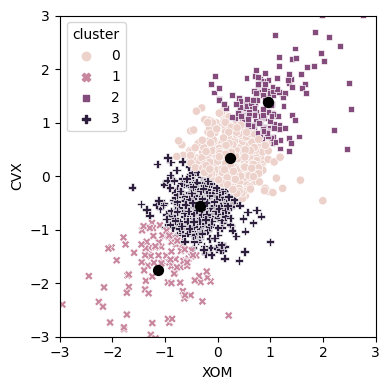

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

## K-Means Algorithm
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations. 

In [16]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Interpreting the Clusters

In [17]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({2: 294, 4: 291, 3: 260, 1: 181, 0: 105})


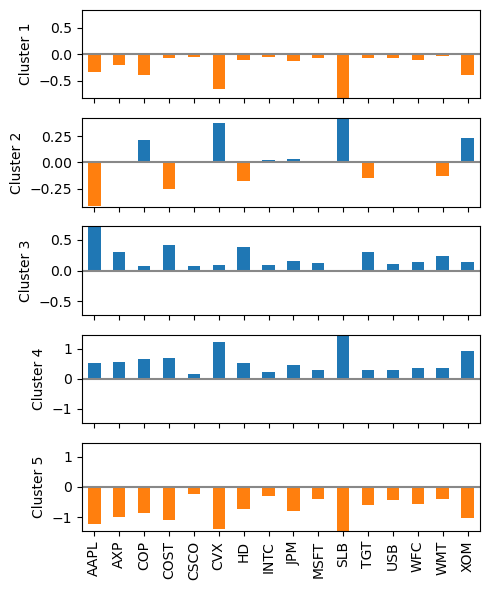

In [11]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

## Selecting the Number of Clusters

C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Gebruiker\Documents\MakeAIWork\miw\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

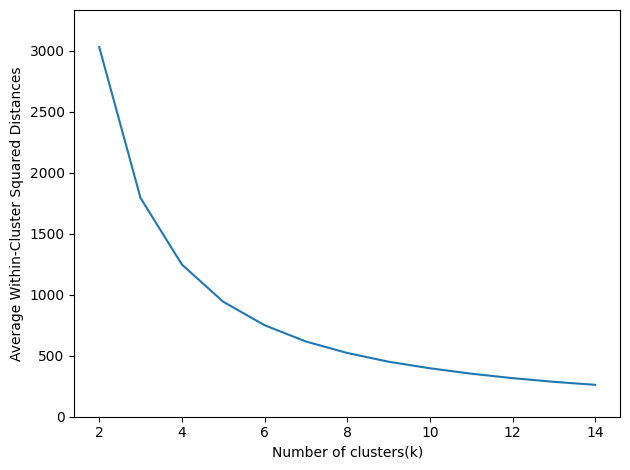

In [18]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Hierarchical Clustering
## A Simple Example

In [21]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


## The Dendrogram

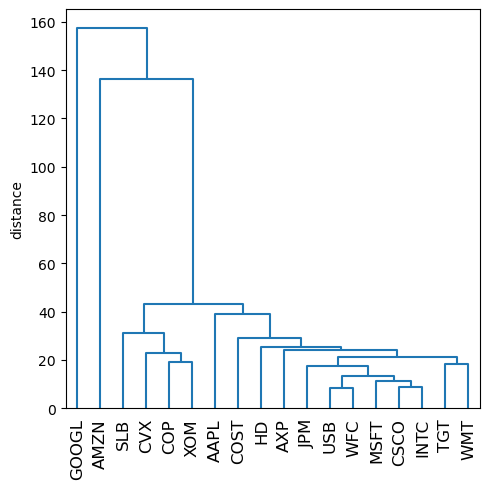

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [15]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


## Measures of Dissimilarity

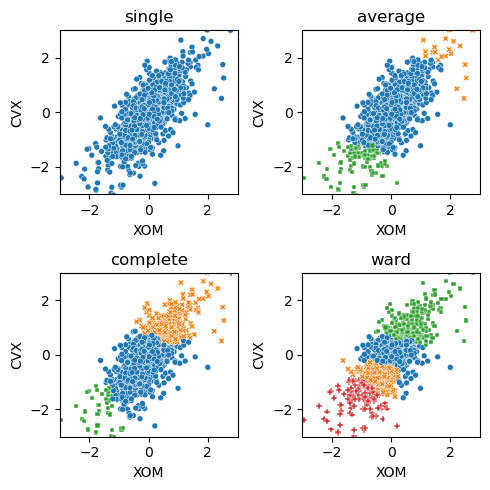

In [16]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

# Model based clustering
## Multivariate Normal Distribution
> Define a colormap that corresponds to the probability levels

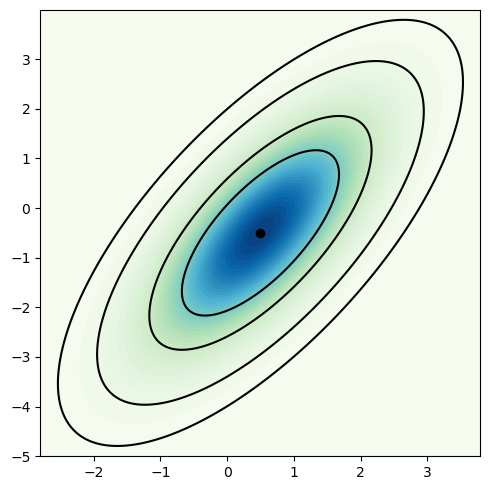

In [17]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

## Mixtures of Normals

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [ ]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

## Selecting the number of clusters

In [ ]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

# Scaling and Categorical Variables
## Scaling the Variables

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

In [ ]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

## Dominant Variables

In [ ]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

## Categorical Data and Gower's Distance
> Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

https://github.com/scikit-learn/scikit-learn/pull/9555/

In [ ]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

## Problems with Clustering Mixed Data

In [ ]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)